In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [22]:
# Load the customer and transaction datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows to understand the structure
print(customers.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


In [23]:
# Convert 'TransactionDate' to datetime for easier manipulation
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Aggregate the transaction data by CustomerID
transaction_data = transactions.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    frequency=('TransactionID', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    recency=('TransactionDate', lambda x: (pd.to_datetime('today') - x.max()).days)
).reset_index()

# Merge the aggregated transaction data with the customer profile data
customer_data = pd.merge(customers, transaction_data, on='CustomerID', how='left')

# Check the merged data
print(customer_data.head())

  CustomerID        CustomerName         Region  SignupDate  total_spending  \
0      C0001    Lawrence Carroll  South America  2022-07-10         3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13         1862.74   
2      C0003      Michael Rivera  South America  2024-03-07         2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09         5354.88   
4      C0005         Laura Weber           Asia  2022-08-15         2034.24   

   frequency  avg_transaction_value  recency  
0        5.0                670.904     86.0  
1        4.0                465.685     55.0  
2        4.0                681.345    156.0  
3        8.0                669.360     35.0  
4        3.0                678.080     84.0  


In [24]:
# One-hot encode the 'Region' column
encoder = OneHotEncoder(sparse=False)
region_encoded = encoder.fit_transform(customer_data[['Region']])
region_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))

# Concatenate the region encoded data with the customer data
customer_data = pd.concat([customer_data, region_df], axis=1)

# Display the updated data with the one-hot encoded 'Region'
print(customer_data.head())

  CustomerID        CustomerName         Region  SignupDate  total_spending  \
0      C0001    Lawrence Carroll  South America  2022-07-10         3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13         1862.74   
2      C0003      Michael Rivera  South America  2024-03-07         2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09         5354.88   
4      C0005         Laura Weber           Asia  2022-08-15         2034.24   

   frequency  avg_transaction_value  recency  Region_Asia  Region_Europe  \
0        5.0                670.904     86.0          0.0            0.0   
1        4.0                465.685     55.0          1.0            0.0   
2        4.0                681.345    156.0          0.0            0.0   
3        8.0                669.360     35.0          0.0            0.0   
4        3.0                678.080     84.0          1.0            0.0   

   Region_North America  Region_South America  
0                   

C:\Users\shekh\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
# Select the relevant features for clustering
features = ['total_spending', 'frequency', 'avg_transaction_value', 'recency'] + list(region_df.columns)
X = customer_data[features]

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Display the first few rows of the scaled features
print(pd.DataFrame(X_scaled, columns=features).head())

   total_spending  frequency  avg_transaction_value   recency  Region_Asia  \
0       -0.061856  -0.011487              -0.070440 -0.259291    -0.538816   
1       -0.879946  -0.468667              -0.937279 -0.698611     1.855921   
2       -0.406876  -0.468667              -0.026337  0.732723    -0.538816   
3        1.035138   1.360054              -0.076962 -0.982043    -0.538816   
4       -0.785896  -0.925848              -0.040129 -0.287634     1.855921   

   Region_Europe  Region_North America  Region_South America  
0       -0.57735             -0.546536              1.545908  
1       -0.57735             -0.546536             -0.646869  
2       -0.57735             -0.546536              1.545908  
3       -0.57735             -0.546536              1.545908  
4       -0.57735             -0.546536             -0.646869  


In [26]:
# Apply KMeans clustering (choosing k=4 for this example)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate the Davies-Bouldin Index to evaluate the clustering
db_index = davies_bouldin_score(X_scaled, customer_data['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')

C:\Users\shekh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\shekh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 1.094511032109084


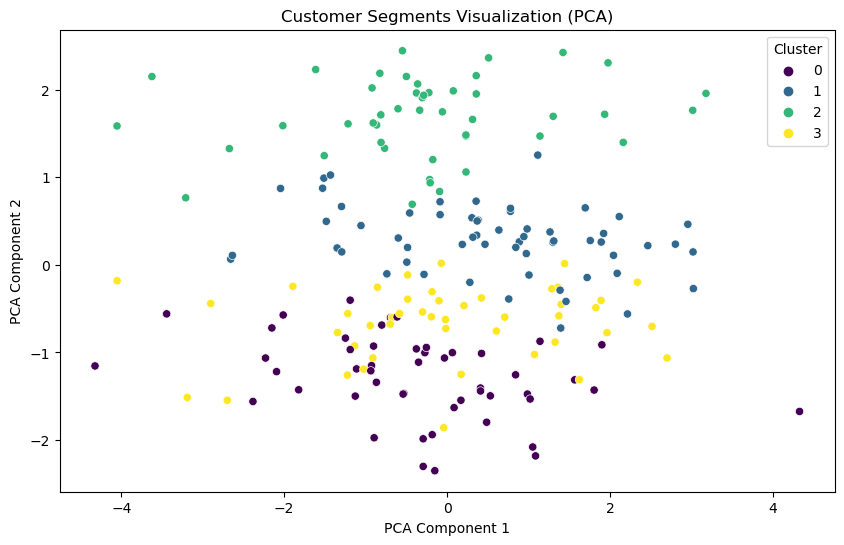

In [27]:
# Reduce the dimensionality of the data to 2D using PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# Plot the clusters in 2D (PCA transformed data)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_data['Cluster'], palette='viridis')
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

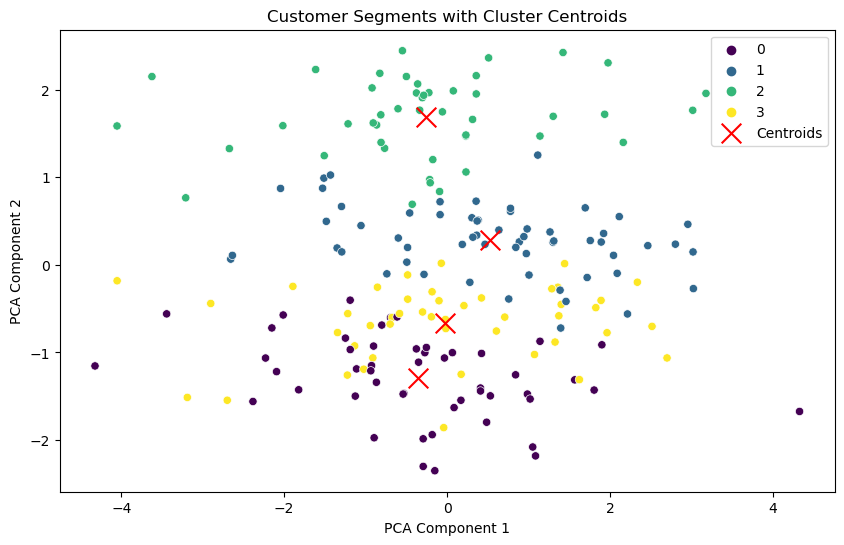

In [28]:
# Visualize the cluster centroids in 2D (after PCA transformation)
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Plot the clusters and centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_data['Cluster'], palette='viridis')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='x', s=200, color='red', label='Centroids')
plt.title('Customer Segments with Cluster Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()
